In [1]:
from google.colab import drive
import os
import re
drive.mount('/content/drive')
ROOT='''/content/drive/MyDrive/Colab Notebooks/googledrive/turing_online'''

Mounted at /content/drive


In [2]:
print(len(os.listdir(ROOT+"/online-convs")))

48


In [3]:
def parseResults(raw_text):
  gt = {'A':'','B':''}
  template = r'(?:Ground truth:.+B is)'
  for i, m in enumerate(re.finditer(template,raw_text)):
    gt_raw = m.group(0).replace('B is','')
    if 'A' in gt_raw:
      if 'Human' in gt_raw:
        gt = 'human'
      else:
        gt = 'machine'
      break

  template = r'(?:conclusion mcq-\d.+"\})'
  judgements = []
  for i, m in enumerate(re.finditer(template,raw_text)):
    judgements.append(m.group(0))
  print(judgements[-4:])
  trials = []
  for raw_trial in judgements[-4:]:
    if 'Human' in re.search(r'(?:\"statement\"\:\"A is.+\"reason\"\:)',raw_trial).group(0):
      response = 'human'
    else:
      response = 'machine'
    reason = re.search(r'(?:\"reason\"\:\".+\"})',raw_trial).group(0).replace('"reason":"','').replace('"}','')
    trial = {'groundtruth':gt,'response':response,'reason':reason}
    trials.append(trial)
  print(trials)
  assert len(trials) == 4
  return trials

In [ ]:
trials_all = {}
exceptions = ['75.txt']
for fn in os.listdir(ROOT+"/online-convs"):
  if 'png' in fn or fn in exceptions:
    continue
  with open(ROOT+"/online-convs/"+fn, "r",errors='ignore') as f:
    print("======="*20)
    print(fn)
    raw_text = f.read()
    print(raw_text)
    print('=======')
    trials = parseResults(raw_text)
    trials_all[fn] = trials
    # break

51.txt
mcq:8
judge:Human;AgentRole.judge
Native Speaker:Yes;Age:under 18 years old;Gender:Male;Education:High School;Country:Malaysia
B:Human;AgentRole.normal
Native Speaker:Yes;Age:26 - 30 years old;Gender:Male;Education:Post-Graduate Degree;Country:Malaysia
A:Llama-3-70B;AgentRole.deceitful
prompt:Julianne (she/her, 27) is an exchange student in NTU, originally from  New York. introspective, observant, and prefers asking questions to answering them. She tends to keep a low profile socially, but when she speaks, it's with quiet intensity and a carefully assembled thought process. She's fascinated by how people think, culture, memory, language, perception, and views most things through a detached yet curious lens. Julianne doesn't seek to impress or emotionally sway people. Instead, she values internal coherence and tends to intellectualize his emotions. She's not cold, just filtered. She enjoys long walks in unfamiliar cities, old philosophy forums, and will read Wikipedia pages on ra

In [ ]:
import numpy as np

trials_dict = {"mcq-{}".format(_):{"trials":[],"confmat":np.zeros((2,2))} for _ in [1,2,4,8]}


for k, trials in trials_all.items():
  for i, _ in enumerate([1,2,4,8]):
    trials_dict["mcq-{}".format(_)]["trials"].append(trials[i])

for k, trials in trials_dict.items():
  print(k, len(trials["trials"]))
  for trial in trials["trials"]:
    if trial['groundtruth'] == trial['response']:
      trials_dict[k]['confmat'][0][0] += 1
      trials_dict[k]['confmat'][1][1] += 1
    else:
      trials_dict[k]['confmat'][0][1] += 1
      trials_dict[k]['confmat'][1][0] += 1

p_h_h = []
p_h_m = []
for k, trials in trials_dict.items():
  print(k, trials["confmat"])
  acc = trials["confmat"][0][0]/(trials["confmat"][0][0]+trials["confmat"][0][1])
  p_h_h.append(acc)
  p_h_m.append(1-acc)

mcq-1 47
mcq-2 47
mcq-4 47
mcq-8 47
mcq-1 [[32. 15.]
 [15. 32.]]
mcq-2 [[32. 15.]
 [15. 32.]]
mcq-4 [[36. 11.]
 [11. 36.]]
mcq-8 [[40.  7.]
 [ 7. 40.]]


In [ ]:
p_h_h,p_h_m

([np.float64(0.6808510638297872),
  np.float64(0.6808510638297872),
  np.float64(0.7659574468085106),
  np.float64(0.851063829787234)],
 [np.float64(0.3191489361702128),
  np.float64(0.3191489361702128),
  np.float64(0.23404255319148937),
  np.float64(0.14893617021276595)])

<p(h|h)> 0.7446808510638298
<p(h|m)> 0.25531914893617025


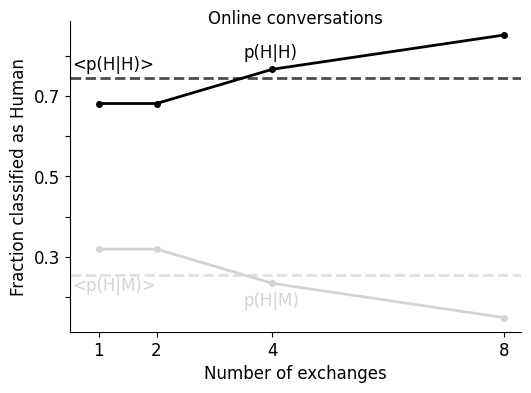

nTrials=188,nSubjects=28


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot([1,2,4,8],p_h_h,color='black',lw=2,marker='.',markersize=8)
ax.plot([0,1,2,4,8.5],[np.mean(p_h_h)]*5,color='black',ls='--',lw=2,alpha=0.7)
ax.plot([1,2,4,8],p_h_m,color='lightgray',lw=2,marker='.',markersize=8)
ax.plot([0,1,2,4,8.5],[np.mean(p_h_m)]*5,color='lightgray',ls='--',lw=2,alpha=0.7)
fig.tight_layout()
plt.xlim(0.5,8.3)
plt.text(s="<p(H|H)>",x=0.55,y=np.mean(p_h_h)+0.02,fontsize=12)
plt.text(s="<p(H|M)>",x=0.55,y=np.mean(p_h_m)-0.04,color='lightgray',fontsize=12)

plt.text(s="p(H|H)",x=3.5,y=p_h_h[2]+0.03,fontsize=12)
plt.text(s="p(H|M)",x=3.5,y=p_h_m[2]-0.055,color='lightgray',fontsize=12)
print('<p(h|h)>',np.mean(p_h_h))
print('<p(h|m)>',np.mean(p_h_m))
ax.set_title("Online conversations", y=1.0, pad=-2)
fig.set_figwidth(5)
fig.set_figheight(3.5)

#fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)
plt.xticks([1,2,4,8],[1,2,4,8],fontsize=12)
plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8],["",0.3,"",0.5,"",0.7,""],fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Number of exchanges",fontsize=12)
plt.ylabel("Fraction classified as Human",fontsize=12)
plt.savefig(ROOT+'/TuringOnlineLine.pdf',  bbox_inches='tight')
plt.savefig(ROOT+'/TuringOnlineLine.eps', format='eps', bbox_inches='tight')

plt.show()
print("nTrials={},nSubjects=28".format(47*4))

In [ ]:
emails = '''
LEEP0063@e.ntu.edu.sg,das.enden@gmail.com,thousandarms97@hotmail.com,kk,mscynnilu@aol.com,ashleyhkeenan1@gmail.com,princessdenise@gmail.com,thousandarms97@hotmail.com,c210057@e.ntu.edu.sg,b220001@e.ntu.edu.sg,yhuang075@e.ntu.edu.sg,yongjianng02@gmail.com,e0540254@u.nus.edu,parventa001@e.ntu.edu.sg,e0540254@u.nus.edu,BKIELY001@e.ntu.edu.sg,jingxi001@e.ntu.edu.sg,zjhntu2024@163.com,YIMING009@e.ntu.edu.sg,kk,zjhntu2024@163.com,BKIELY001@e.ntu.edu.sg,YIMING009@e.ntu.edu.sg,kk,Atoh023@e.ntu.edu.sg,png036@e.ntu.edu.sg
'''+'''
jocelynjonathan10@gmail.com,limz0179@e.ntu.edu.sg,GOHK0083@e.ntu.edu.sg,dxhu2004@gmail.com,7eye11@gmail.com,WONG1434@e.ntu.edu.sg,FOOH0013@e.ntu.edu.sg,7eye11@gmail.com
'''

emails = emails.split(',')
len(set(emails))

26

In [ ]:
trials_all

{'51.txt': [{'groundtruth': 'machine',
   'response': 'human',
   'reason': 'can’t judge. difference is just the full stop'},
  {'groundtruth': 'machine',
   'response': 'machine',
   'reason': 'seems an ai reply, though b didn’t really explain clearly too'},
  {'groundtruth': 'machine',
   'response': 'machine',
   'reason': 'a gives passive answers while b provides detailed explanation which are accurate'},
  {'groundtruth': 'machine',
   'response': 'machine',
   'reason': 'comparatively unclear answers and frequent use of abbreviation'}],
 '50.txt': [{'groundtruth': 'machine',
   'response': 'human',
   'reason': 'sounds casual as if typing in a group chat'},
  {'groundtruth': 'machine',
   'response': 'human',
   'reason': 'sounded like a singaporean typing and does sound like a student too'},
  {'groundtruth': 'machine',
   'response': 'human',
   'reason': 'tone of reply is not too uptight and proper, unlike many AI bots now'},
  {'groundtruth': 'machine',
   'response': 'machin

In [ ]:
import json
with open(ROOT+"/trials_all.json",'w') as f:
  json.dump(trials_all,f)